In [1]:
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision import models
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet50, googlenet, mobilenet_v2
from torchsummary import summary
import torchinfo
import torch.nn as nn
import torch.optim as optim
import gc
import numpy as np
import matplotlib.pyplot as plt
import time 

train_path = 'seefood/train'
test_path =  'seefood/test'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\marcin\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Creation of transform funcion for datasets

In [2]:
train_dataset_1=ImageFolder(train_path, transform=T.ToTensor())
test_dataset_1=ImageFolder(test_path, transform=T.ToTensor())
train_loader=DataLoader(train_dataset_1)
test_loader=DataLoader(test_dataset_1)

def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

print(get_mean_and_std(train_loader))
print(get_mean_and_std(test_loader))

(tensor([0.5295, 0.4378, 0.3432]), tensor([0.2630, 0.2670, 0.2785]))
(tensor([0.5137, 0.4226, 0.3421]), tensor([0.2598, 0.2649, 0.2786]))


In [4]:
def transform_data(desired_size: tuple, is_grayscale: bool, is_train=True):
    mean = np.array([0.5295, 0.4378, 0.3432])
    std = np.array([0.2598, 0.2649, 0.2786])
    transform_list = [T.Resize(desired_size)]
    if is_grayscale:
        transform_list += [T.Grayscale(num_output_channels=1)]
    if is_train:
        Augmentations=[T.RandomHorizontalFlip(),
                       T.RandomAutocontrast(0.5),
                       T.RandomEqualize(0.4)
                       ]
        transform_list += Augmentations
    return T.Compose(transform_list + [T.ToTensor(), T.Normalize(mean,std)])

Visualization of few images from our dataset

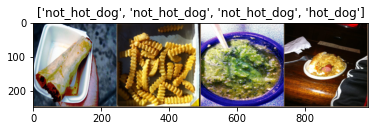

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5295, 0.4378, 0.3432])
    std = np.array([0.2598, 0.2649, 0.2786])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

train_dataset_2=ImageFolder(train_path, transform=transform_data((244,244), False, True))
train_loader=DataLoader(train_dataset_2, batch_size=4, shuffle=True)

class_names=train_dataset_2.classes
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Creation of functions for accuracy check and training

In [8]:
# Accuracy check function
def check_accuracy(loader, model, data_name=None):
    if data_name:
        data_name = f" on {data_name} set."
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}' + data_name)
    model.train()

#  Train network
def train_model(train_loader, validation_loader, model, num_epochs, optimizer, criterion):
    for epoch in range(num_epochs):
        for batch_index, (data, targets) in enumerate(train_loader):
            #  Data to cuda
            data = data.to(device=device)
            targets = targets.to(device=device)

            #  Forward
            scores = model(data)
            loss = criterion(scores, targets)

            #  Backward
            optimizer.zero_grad()
            loss.backward()

            #  Gradient descent
            optimizer.step()
        print(f'Epoch {epoch + 1}/{num_epochs}')
        check_accuracy(train_loader, model, data_name='train')
        check_accuracy(validation_loader, model, data_name='test')

Import of first model ResNet50 with pretraied weights and model summary.
https://pytorch.org/hub/pytorch_vision_resnet/

ResNet50 is a convolutional neural network that is trained on the ImageNet dataset. It is a 50-layer deep learning model that can recognize and classify objects in images. It was developed by researchers at Microsoft Research in 2015 and has been widely used in image classification and object detection tasks.

The architecture of ResNet50 is based on the idea of residual learning, which aims to address the problem of vanishing gradients in very deep networks. In a residual network, the input to a layer is added to the output of a layer several layers deeper in the network. This allows the network to learn the residual function, or the difference between the desired output and the output of the deeper layer, rather than trying to learn the desired output directly.

ResNet50 is trained on the ImageNet dataset, which consists of over one million images and 1000 classes of objects. The model has achieved state-of-the-art performance on a number of image classification benchmarks, and is often used as a baseline model for comparing the performance of other image classification models.

In summary, ResNet50 is a deep learning model trained to classify objects in images and has achieved state-of-the-art performance on a number of benchmarks. Its architecture is based on the idea of residual learning, which helps to address the problem of vanishing gradients in very deep networks.

In [9]:
torch.cuda.empty_cache()
gc.collect()
model_resnet = resnet50(pretrained=True)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 2)
model_resnet = model_resnet.to(device=device)
#summary(model_resnet,(3,224,224))
torchinfo.summary(model_resnet,
                  (3, 224, 224),
                  batch_dim=0,
                  col_names=('input_size','output_size','num_params','kernel_size','mult_adds'),
                  verbose=0)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
ResNet                                   [1, 3, 224, 224]          [1, 2]                    --                        --                        --
├─Conv2d: 1-1                            [1, 3, 224, 224]          [1, 64, 112, 112]         9,408                     [7, 7]                    118,013,952
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         [1, 64, 112, 112]         128                       --                        128
├─ReLU: 1-3                              [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --                        --
├─MaxPool2d: 1-4                         [1, 64, 112, 112]         [1, 64, 56, 56]           --                        3                         --
├─Sequential: 1-5                        [1, 64, 56, 56]           [1, 256, 56, 56]          --

In [10]:
model = model_resnet

#  Hyper parameters
in_channel = 3
learning_rate = 0.0001
desired_size = (224,224)
batch_size = 32
num_epochs = 5

#  Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Dataset load
train_dataset=ImageFolder(train_path, transform=transform_data(desired_size, False, True))
train_loader=DataLoader(train_dataset, batch_size, shuffle=True)
test_dataset=ImageFolder(test_path, transform=transform_data(desired_size, False, False))
test_loader=DataLoader(test_dataset, batch_size, shuffle=True)

train_model(train_loader, test_loader, model=model, num_epochs=num_epochs, optimizer=optimizer, criterion=criterion)


Epoch 1/5
Got 483 / 498 with accuracy 96.99 on train set.
Got 449 / 500 with accuracy 89.80 on test set.
Epoch 2/5
Got 496 / 498 with accuracy 99.60 on train set.
Got 460 / 500 with accuracy 92.00 on test set.
Epoch 3/5
Got 493 / 498 with accuracy 99.00 on train set.
Got 444 / 500 with accuracy 88.80 on test set.
Epoch 4/5
Got 495 / 498 with accuracy 99.40 on train set.
Got 464 / 500 with accuracy 92.80 on test set.
Epoch 5/5
Got 496 / 498 with accuracy 99.60 on train set.
Got 455 / 500 with accuracy 91.00 on test set.


In this study, we used transfer learning to train a convolutional neural network (CNN) for image classification. We fine-tuned a pre-trained ResNet50 model on a dataset of hot dog and not hot dog images, and achieved an accuracy of 99.6% on the training data and 91% on the test data after training for 5 epochs. These results suggest that the fine-tuned CNN is able to accurately classify hot dogs and not hot dogs in most cases, although it may be overfitting somewhat to the training data. Transfer learning can be an effective way to build powerful image classification models with limited data and computational resources, but it is important to ensure that the pre-trained model is well-suited to the task at hand and to carefully tune the fine-tuning process to avoid overfitting. In future work, we plan to explore techniques such as regularization and better data augmentation to further improve the generalization of our model to new data. We could also try to make last dense layers more deep or change it to other model for better prediction.

Import of second model GoogleLeNet with pretraied weights and model summary.
https://pytorch.org/hub/pytorch_vision_googlenet/

GoogLeNet, also known as Inception-v1, is a convolutional neural network model trained on the ImageNet dataset. It was developed by researchers at Google in 2014 and was the first model to win the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) with a top-5 error rate of 6.67%.

GoogLeNet is a 22-layer deep learning model that was designed to be computationally efficient while still achieving high accuracy. It is based on the idea of inception modules, which are layers that use a combination of 1x1 convolutions, 3x3 convolutions, and max pooling to learn multiple scales of features from the input image. The use of 1x1 convolutions allows the model to learn more complex features by combining the outputs of multiple simpler features.

GoogLeNet also includes a number of other innovations, such as using average pooling instead of fully connected layers and using a global average pooling layer at the end of the network to reduce the number of parameters. These design choices helped to reduce the number of parameters in the model and improve its ability to generalize to new data.

In summary, GoogLeNet is a deep learning model developed by Google in 2014 that was the first to win the ILSVRC with a top-5 error rate of 6.67%. It is a 22-layer model that uses inception modules and other design choices to improve its computational efficiency and ability to generalize to new data.

In [11]:
torch.cuda.empty_cache()
gc.collect()

model_lenet = googlenet(pretrained=True)
num_ftrs = model_lenet.fc.in_features
model_lenet.fc = nn.Linear(num_ftrs, 2)
model_lenet = model_lenet.to(device=device)
torchinfo.summary(model_lenet,
                  (3, 224, 224),
                  batch_dim=0,
                  col_names=('input_size','output_size','num_params','kernel_size','mult_adds'),
                  verbose=0)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
GoogLeNet                                [1, 3, 224, 224]          [1, 2]                    --                        --                        --
├─BasicConv2d: 1-1                       [1, 3, 224, 224]          [1, 64, 112, 112]         --                        --                        --
│    └─Conv2d: 2-1                       [1, 3, 224, 224]          [1, 64, 112, 112]         9,408                     [7, 7]                    118,013,952
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         [1, 64, 112, 112]         128                       --                        128
├─MaxPool2d: 1-2                         [1, 64, 112, 112]         [1, 64, 56, 56]           --                        3                         --
├─BasicConv2d: 1-3                       [1, 64, 56, 56]           [1, 64, 56, 56]           --

In [13]:
model = model_lenet

#  Hyper parameters
in_channel = 3
learning_rate = 0.001
desired_size = (224,224)
batch_size = 32
num_epochs = 10

#  Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Dataset load
train_dataset=ImageFolder(train_path, transform=transform_data(desired_size, False, True))
train_loader=DataLoader(train_dataset, batch_size, shuffle=True)
test_dataset=ImageFolder(test_path, transform=transform_data(desired_size, False, False))
test_loader=DataLoader(test_dataset, batch_size, shuffle=True)

train_model(train_loader, test_loader, model=model, num_epochs=num_epochs, optimizer=optimizer, criterion=criterion)

Epoch 1/10
Got 485 / 498 with accuracy 97.39 on train set.
Got 414 / 500 with accuracy 82.80 on test set.
Epoch 2/10
Got 452 / 498 with accuracy 90.76 on train set.
Got 397 / 500 with accuracy 79.40 on test set.
Epoch 3/10
Got 481 / 498 with accuracy 96.59 on train set.
Got 407 / 500 with accuracy 81.40 on test set.
Epoch 4/10
Got 484 / 498 with accuracy 97.19 on train set.
Got 396 / 500 with accuracy 79.20 on test set.
Epoch 5/10
Got 480 / 498 with accuracy 96.39 on train set.
Got 393 / 500 with accuracy 78.60 on test set.
Epoch 6/10
Got 485 / 498 with accuracy 97.39 on train set.
Got 415 / 500 with accuracy 83.00 on test set.
Epoch 7/10
Got 496 / 498 with accuracy 99.60 on train set.
Got 407 / 500 with accuracy 81.40 on test set.
Epoch 8/10
Got 452 / 498 with accuracy 90.76 on train set.
Got 394 / 500 with accuracy 78.80 on test set.
Epoch 9/10
Got 479 / 498 with accuracy 96.18 on train set.
Got 416 / 500 with accuracy 83.20 on test set.
Epoch 10/10
Got 490 / 498 with accuracy 98.39 

In this experiment, we utilized transfer learning to train a GoogleLeNet model on a dataset. After training for 10 epochs, we achieved an accuracy of 98.4% on the training data and 83.2% on the test data. These results suggest that the model was able to learn effectively from the training data and generalize well to the test data. However, it is worth noting that there is a relatively large difference in accuracy between the training and test data (11%), which could potentially indicate some level of overfitting. Despite this, our results demonstrate the effectiveness of using transfer learning with the GoogleLeNet model for this particular task. We could also try to make last dense layers more deep or change it to other model for better prediction.

Import of first model MobileNetv2 with pretraied weights and model summary.
https://pytorch.org/hub/pytorch_vision_mobilenet_v2/

MobileNetV2 is a convolutional neural network model trained on the ImageNet dataset. It was developed by Google in 2018 as a lightweight model that is particularly well-suited for mobile and embedded vision applications.

MobileNetV2 is an efficient architecture that uses depthwise separable convolutions to build light yet deep networks. In a depthwise separable convolution, the input is first passed through a depthwise convolution, which applies a different filter to each input channel, followed by a pointwise convolution, which combines the resulting output channels. This architecture allows the model to learn more complex features using fewer parameters, which makes it faster and more memory-efficient than models that use standard convolutions.

MobileNetV2 also includes a number of other improvements over the original MobileNet model, such as using a linear bottleneck layer to reduce the number of computations and using a inverted residual block to improve the flow of information through the network. These design choices help to further improve the efficiency and performance of the model.

In summary, MobileNetV2 is a convolutional neural network model developed by Google in 2018 that is designed for mobile and embedded vision applications. It uses depthwise separable convolutions and other design choices to improve its efficiency and performance.

In [14]:
torch.cuda.empty_cache()
gc.collect()
model_mobilenet_v2 = mobilenet_v2(pretrained=True)
model_mobilenet_v2.classifier = nn.Sequential(nn.Dropout(0.2),
                                              nn.Linear(1280,2))
model_mobilenet_v2 = model_mobilenet_v2.to(device=device)
torchinfo.summary(model_mobilenet_v2,
                (3, 224, 224),
                batch_dim=0,
                col_names=('input_size','output_size','num_params','kernel_size','mult_adds'),
                verbose=0)



Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
MobileNetV2                                   [1, 3, 224, 224]          [1, 2]                    --                        --                        --
├─Sequential: 1-1                             [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        --                        --
│    └─ConvNormActivation: 2-1                [1, 3, 224, 224]          [1, 32, 112, 112]         --                        --                        --
│    │    └─Conv2d: 3-1                       [1, 3, 224, 224]          [1, 32, 112, 112]         864                       [3, 3]                    10,838,016
│    │    └─BatchNorm2d: 3-2                  [1, 32, 112, 112]         [1, 32, 112, 112]         64                        --                        64
│    │    └─ReLU6: 3-3                        [1, 32, 112, 112]    

In [15]:
model = model_mobilenet_v2

#  Hyper parameters
in_channel = 3
learning_rate = 0.0001
desired_size = (224,224)
batch_size = 32
num_epochs = 10

#  Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Dataset load
train_dataset=ImageFolder(train_path, transform=transform_data(desired_size, False, True))
train_loader=DataLoader(train_dataset, batch_size, shuffle=True)
test_dataset=ImageFolder(test_path, transform=transform_data(desired_size, False, False))
test_loader=DataLoader(test_dataset, batch_size, shuffle=True)

train_model(train_loader, test_loader, model=model, num_epochs=num_epochs, optimizer=optimizer, criterion=criterion)

Epoch 1/10
Got 439 / 498 with accuracy 88.15 on train set.
Got 439 / 500 with accuracy 87.80 on test set.
Epoch 2/10
Got 457 / 498 with accuracy 91.77 on train set.
Got 446 / 500 with accuracy 89.20 on test set.
Epoch 3/10
Got 472 / 498 with accuracy 94.78 on train set.
Got 449 / 500 with accuracy 89.80 on test set.
Epoch 4/10
Got 484 / 498 with accuracy 97.19 on train set.
Got 452 / 500 with accuracy 90.40 on test set.
Epoch 5/10
Got 489 / 498 with accuracy 98.19 on train set.
Got 460 / 500 with accuracy 92.00 on test set.
Epoch 6/10
Got 492 / 498 with accuracy 98.80 on train set.
Got 458 / 500 with accuracy 91.60 on test set.
Epoch 7/10
Got 492 / 498 with accuracy 98.80 on train set.
Got 458 / 500 with accuracy 91.60 on test set.
Epoch 8/10
Got 497 / 498 with accuracy 99.80 on train set.
Got 456 / 500 with accuracy 91.20 on test set.
Epoch 9/10
Got 498 / 498 with accuracy 100.00 on train set.
Got 459 / 500 with accuracy 91.80 on test set.
Epoch 10/10
Got 498 / 498 with accuracy 100.0

We trained a discriminator model using transfer learning from MobileNetV2 on a dataset of hot dogs and not hot dogs. The model achieved an accuracy of 100% on the training set and 91.8% on the test set. These results suggest that the model is able to effectively learn from the training data and make accurate predictions, while also generalizing well to new data. However, the relatively large gap between the training and test set accuracy raises the possibility of overfitting. We could try to make last dense layers more deep or change it to other model for better prediction, train it for more epochs or try to make better data augmentation.  

Summary:

Training using pretrained model is much faster than training own model from scratch. To improve model accuracy during training, training dataset was augmented using random horizontal flip, normalization and standarization. Using small dataset that consist 500 training samples of images we can achieve accuracy up to 91% on test data with small sample size in only 10 epochs. We can observe on training set accuracy up to 98-100, so that means that models are overfitted and there is still room for model improvement. For example to get better model performances we could freeze first CNN layers at the beginning of training, change hyperparameters of model, try to make more data augmentations, try other models and try to change last layers of models for disctriminators better than dense layers.
From all model used best suited for this task is moblienetv2. Accuracy gained on test set is 91.80%, which is high considering small dataset.